In [2]:
import numpy as np
import scipy as sp
import scipy.stats
import itertools
import logging
import matplotlib.pyplot as plt
import pandas as pd
import torch.utils.data as utils
import math
import time
import tqdm

import torch
import torch.optim as optim
import torch.nn.functional as F
from argparse import ArgumentParser
from torch.distributions import MultivariateNormal

import torch.nn as nn
import torch.nn.init as init

from flows import RealNVP, Planar
from models import NormalizingFlowModel

## Load and process the data

In [3]:
mode = 'ROC'

In [4]:
f_rnd = pd.read_hdf("/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_rnd.h5")

In [5]:
f_rnd.head()

,Mjj,j1 pT,j2 pT,Mj1,j1 tau21,j1 tau32,j1 tau43,j1 tau54,j1 tau65,j1 tau76,...,j2 tau87,j2 sqrt(tau^2_1)/tau^1_1,j2 n_trk,j2 M_trim,j2 M_prun,j2 M_mmdt,j2 M_sdb1,j2 M_sdb2,j2 M_sdm1,isSignal
0,2577.571899,1285.895950,1282.286017,98.677270,0.528903,0.788281,0.904471,0.881570,0.911651,0.869766,...,0.865858,1.895988,128.0,42.162664,18.466533,18.466533,31.845136,42.162664,0.000000,0.0
1,3807.507389,1334.493332,1306.137883,584.595432,0.345626,0.463461,0.865982,0.892948,0.843223,0.939763,...,0.934968,1.377217,348.0,395.226881,393.309512,405.034096,405.034096,405.034096,405.034096,0.0
2,1710.965414,1072.462085,678.557182,159.597526,0.677692,0.690707,0.695322,0.823351,0.861655,0.909383,...,0.902637,1.887494,236.0,54.235070,41.967840,41.352112,51.721630,70.442364,-0.000003,0.0
3,2603.379037,1284.020224,1217.031950,515.237299,0.091038,0.784454,0.860716,0.887306,0.885916,0.950761,...,0.924068,1.997360,352.0,81.842001,60.307703,60.307703,72.423677,84.480859,0.000003,0.0
4,3294.162200,1205.343324,1087.658980,142.420213,0.507714,0.522686,0.904070,0.908468,0.918753,0.928911,...,0.906367,1.113248,204.0,103.456059,99.817788,103.456059,103.456059,103.456059,0.000008,1.0


In [7]:
if mode == 'ROC':
    dt = f_rnd.values
else:
    dt_PureBkg = dt_PureBkg = f_PureBkg.values

In [14]:
correct = (dt[:,3]>20) &(dt[:,19]>20) & (dt[:, 4] > 0)& (dt[:, 5] > 0)& (dt[:, 6] > 0)& (dt[:, 7] > 0)& (dt[:, 8] > 0) & (dt[:, 20] > 0)& (dt[:, 21] > 0)& (dt[:, 22] > 0)& (dt[:, 23] > 0)& (dt[:, 24] > 0) & (dt[:, 25] > 0)& (dt[:, 26] > 0)


In [15]:
dt = dt[correct]

In [16]:
dt.shape

(1092741, 36)

In [17]:
for i in [4,5,6,7,8,9,10, 20, 21, 22, 23, 24, 25,26]:
    #X[:,i] = (X[:,i]-np.mean(X[:,i]))/np.std(X[:,i])
    dt[:,i] = ((dt[:,i]-np.min(dt[:,i]))/(np.max(dt[:,i])-np.min(dt[:,i])))

In [18]:
for i in range(13,19):
    dt[:,i] = dt[:,i]/dt[:,3]

In [19]:
for i in range(29,35):
    dt[:,i] = dt[:,i]/(dt[:,19])

In [20]:
for i in [11,27,12,28,3,19]:
    dt[:,i] = (dt[:,i]-np.min(dt[:,i]))/(np.max(dt[:,i])-np.min(dt[:,i]))

In [21]:
X = np.concatenate((dt[:,3:18], dt[:,19:34]), axis=1)

In [22]:
X.shape

(1092741, 30)

In [23]:
idx = dt[:,-1]
bkg_idx = np.where(idx==0)[0]
signal_idx = np.where(idx==1)[0]

In [24]:
total_PureBkg = torch.tensor(X[bkg_idx])

total_PureBkg_selection = total_PureBkg

In [25]:
total_PureBkg_selection.shape

torch.Size([992916, 30])

In [27]:
bs = 2000
bkgAE_train_iterator = utils.DataLoader(total_PureBkg_selection, batch_size=bs, shuffle=True) 
bkgAE_test_iterator = utils.DataLoader(total_PureBkg_selection, batch_size=bs)

## Build the model

In [31]:
class VAE_NF(nn.Module):
    def __init__(self, K, D):
        super().__init__()
        self.dim = D
        self.K = K
        self.encoder = nn.Sequential(
            nn.Linear(30, 64),
            nn.LeakyReLU(True),
            nn.Linear(64, 48),
            nn.LeakyReLU(True),            
            nn.Linear(48, D * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(D, 48),
            nn.LeakyReLU(True),
            nn.Linear(48, 64),
            nn.LeakyReLU(True),
            nn.Linear(64, 30),
            nn.Sigmoid()
        )
        
        flow_init = Planar(dim=D)
        flows_init = [flow_init for _ in range(K)]
        prior = MultivariateNormal(torch.zeros(D).cuda(), torch.eye(D).cuda())
        self.flows = NormalizingFlowModel(prior, flows_init)

    def forward(self, x):
        # Run Encoder and get NF params
        enc = self.encoder(x)
        mu = enc[:, :self.dim]
        log_var = enc[:, self.dim: self.dim * 2]

        # Re-parametrize
        sigma = (log_var * .5).exp()
        z = mu + sigma * torch.randn_like(sigma)
        kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        # Construct more expressive posterior with NF
        
        z_k, _, sum_ladj = self.flows(z)
        
        kl_div = kl_div / x.size(0) - sum_ladj.mean()  # mean over batch

        # Run Decoder
        x_prime = self.decoder(z_k)
        return x_prime, kl_div

## Creating Instance¶

In [32]:
N_EPOCHS = 30
PRINT_INTERVAL = 2000
NUM_WORKERS = 4
LR = 1e-4

N_FLOWS = 4
Z_DIM = 6

n_steps = 0

In [33]:
model = VAE_NF(N_FLOWS, Z_DIM).cuda()

In [34]:
optimizer = optim.Adam(model.parameters(), lr=LR)

In [35]:
def train():
    global n_steps
    train_loss = []
    model.train()

    for batch_idx, x in enumerate(bkgAE_train_iterator):
        start_time = time.time()
        
        x = x.float().cuda()

        x_tilde, kl_div = model(x)
        loss_recons = F.binary_cross_entropy(x_tilde, x, size_average=False) / x.size(0)
        loss = loss_recons + kl_div

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss.append([loss_recons.item(), kl_div.item()])

        if (batch_idx + 1) % PRINT_INTERVAL == 0:
            print('\tIter [{}/{} ({:.0f}%)]\tLoss: {} Time: {:5.3f} ms/batch'.format(
                batch_idx * len(x), 50000,
                PRINT_INTERVAL * batch_idx / 50000,
                np.asarray(train_loss)[-PRINT_INTERVAL:].mean(0),
                1000 * (time.time() - start_time)
            ))

        n_steps += 1

In [36]:
def evaluate(split='valid'):
    global n_steps
    start_time = time.time()
    val_loss = []
    model.eval()

    with torch.no_grad():
        for batch_idx, x in enumerate(bkgAE_test_iterator):
            
            x = x.float().cuda()

            x_tilde, kl_div = model(x)
            loss_recons = F.binary_cross_entropy(x_tilde, x, size_average=False) / x.size(0)
            loss = loss_recons + kl_div

            val_loss.append(loss.item())
            #writer.add_scalar('loss/{}/ELBO'.format(split), loss.item(), n_steps)
            #writer.add_scalar('loss/{}/reconstruction'.format(split), loss_recons.item(), n_steps)
            #writer.add_scalar('loss/{}/KL'.format(split), kl_div.item(), n_steps)

    print('\nEvaluation Completed ({})!\tLoss: {:5.4f} Time: {:5.3f} s'.format(
        split,
        np.asarray(val_loss).mean(0),
        time.time() - start_time
    ))
    return np.asarray(val_loss).mean(0)

In [37]:
print(model)

VAE_NF(
  (encoder): Sequential(
    (0): Linear(in_features=30, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=True)
    (2): Linear(in_features=64, out_features=48, bias=True)
    (3): LeakyReLU(negative_slope=True)
    (4): Linear(in_features=48, out_features=12, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=6, out_features=48, bias=True)
    (1): LeakyReLU(negative_slope=True)
    (2): Linear(in_features=48, out_features=64, bias=True)
    (3): LeakyReLU(negative_slope=True)
    (4): Linear(in_features=64, out_features=30, bias=True)
    (5): Sigmoid()
  )
  (flows): NormalizingFlowModel(
    (flows): ModuleList(
      (0): Planar()
      (1): Planar()
      (2): Planar()
      (3): Planar()
    )
  )
)


In [42]:
N_EPOCHS = 10
BEST_LOSS = 99999999
LAST_SAVED = -1
PATIENCE_COUNT = 0
PATIENCE_LIMIT = 5
for epoch in range(1, 1000):
    print("Epoch {}:".format(epoch))
    train()
    cur_loss = evaluate()

    if cur_loss <= BEST_LOSS:
        PATIENCE_COUNT = 0
        BEST_LOSS = cur_loss
        LAST_SAVED = epoch
        print("Saving model!")
        if mode == 'ROC':
            torch.save(model.state_dict(),"/data/t3home000/spark/QUASAR/weights/bkg_vae_NF_planar_RND_conventionaltau.h5")
        else:
            torch.save(model.state_dict(), "/data/t3home000/spark/QUASAR/weights/bkg_vae_NF_planar_PureBkg_22var.h5")
    else:
        PATIENCE_COUNT += 1
        print("Not saving model! Last saved: {}".format(LAST_SAVED))
        if PATIENCE_COUNT > 5:
            print("Patience Limit Reached")
            break 

Epoch 1:

Evaluation Completed (valid)!	Loss: 7.1840 Time: 3.130 s
Saving model!
Epoch 2:

Evaluation Completed (valid)!	Loss: 7.1825 Time: 3.270 s
Saving model!
Epoch 3:

Evaluation Completed (valid)!	Loss: 7.1811 Time: 3.465 s
Saving model!
Epoch 4:

Evaluation Completed (valid)!	Loss: 7.1778 Time: 3.387 s
Saving model!
Epoch 5:

Evaluation Completed (valid)!	Loss: 7.1771 Time: 3.523 s
Saving model!
Epoch 6:

Evaluation Completed (valid)!	Loss: 7.1745 Time: 3.359 s
Saving model!
Epoch 7:

Evaluation Completed (valid)!	Loss: 7.1711 Time: 4.091 s
Saving model!
Epoch 8:

Evaluation Completed (valid)!	Loss: 7.1696 Time: 3.703 s
Saving model!
Epoch 9:

Evaluation Completed (valid)!	Loss: 7.1690 Time: 3.475 s
Saving model!
Epoch 10:

Evaluation Completed (valid)!	Loss: 7.1653 Time: 3.347 s
Saving model!
Epoch 11:

Evaluation Completed (valid)!	Loss: 7.1632 Time: 3.402 s
Saving model!
Epoch 12:

Evaluation Completed (valid)!	Loss: 7.1602 Time: 3.457 s
Saving model!
Epoch 13:

Evaluation Com


Evaluation Completed (valid)!	Loss: 6.9892 Time: 4.117 s
Saving model!
Epoch 102:

Evaluation Completed (valid)!	Loss: 6.9867 Time: 3.911 s
Saving model!
Epoch 103:

Evaluation Completed (valid)!	Loss: 6.9836 Time: 3.971 s
Saving model!
Epoch 104:

Evaluation Completed (valid)!	Loss: 6.9834 Time: 4.059 s
Saving model!
Epoch 105:

Evaluation Completed (valid)!	Loss: 6.9812 Time: 3.644 s
Saving model!
Epoch 106:

Evaluation Completed (valid)!	Loss: 6.9791 Time: 3.395 s
Saving model!
Epoch 107:

Evaluation Completed (valid)!	Loss: 6.9780 Time: 3.117 s
Saving model!
Epoch 108:

Evaluation Completed (valid)!	Loss: 6.9762 Time: 3.271 s
Saving model!
Epoch 109:

Evaluation Completed (valid)!	Loss: 6.9758 Time: 4.014 s
Saving model!
Epoch 110:

Evaluation Completed (valid)!	Loss: 6.9737 Time: 4.328 s
Saving model!
Epoch 111:

Evaluation Completed (valid)!	Loss: 6.9708 Time: 4.251 s
Saving model!
Epoch 112:

Evaluation Completed (valid)!	Loss: 6.9706 Time: 3.638 s
Saving model!
Epoch 113:

Eva


Evaluation Completed (valid)!	Loss: 6.8304 Time: 3.344 s
Saving model!
Epoch 200:

Evaluation Completed (valid)!	Loss: 6.8279 Time: 3.916 s
Saving model!
Epoch 201:

Evaluation Completed (valid)!	Loss: 6.8278 Time: 3.740 s
Saving model!
Epoch 202:

Evaluation Completed (valid)!	Loss: 6.8261 Time: 3.167 s
Saving model!
Epoch 203:

Evaluation Completed (valid)!	Loss: 6.8244 Time: 3.476 s
Saving model!
Epoch 204:

Evaluation Completed (valid)!	Loss: 6.8226 Time: 3.567 s
Saving model!
Epoch 205:

Evaluation Completed (valid)!	Loss: 6.8199 Time: 3.336 s
Saving model!
Epoch 206:

Evaluation Completed (valid)!	Loss: 6.8193 Time: 3.541 s
Saving model!
Epoch 207:

Evaluation Completed (valid)!	Loss: 6.8175 Time: 3.387 s
Saving model!
Epoch 208:

Evaluation Completed (valid)!	Loss: 6.8170 Time: 3.841 s
Saving model!
Epoch 209:

Evaluation Completed (valid)!	Loss: 6.8158 Time: 3.409 s
Saving model!
Epoch 210:

Evaluation Completed (valid)!	Loss: 6.8144 Time: 3.695 s
Saving model!
Epoch 211:

Eva


Evaluation Completed (valid)!	Loss: 6.6969 Time: 4.231 s
Saving model!
Epoch 297:

Evaluation Completed (valid)!	Loss: 6.6959 Time: 3.364 s
Saving model!
Epoch 298:

Evaluation Completed (valid)!	Loss: 6.6953 Time: 3.797 s
Saving model!
Epoch 299:

Evaluation Completed (valid)!	Loss: 6.6923 Time: 3.131 s
Saving model!
Epoch 300:

Evaluation Completed (valid)!	Loss: 6.6914 Time: 3.720 s
Saving model!
Epoch 301:

Evaluation Completed (valid)!	Loss: 6.6904 Time: 3.067 s
Saving model!
Epoch 302:

Evaluation Completed (valid)!	Loss: 6.6896 Time: 3.387 s
Saving model!
Epoch 303:

Evaluation Completed (valid)!	Loss: 6.6901 Time: 3.479 s
Not saving model! Last saved: 302
Epoch 304:

Evaluation Completed (valid)!	Loss: 6.6882 Time: 3.450 s
Saving model!
Epoch 305:

Evaluation Completed (valid)!	Loss: 6.6858 Time: 3.793 s
Saving model!
Epoch 306:

Evaluation Completed (valid)!	Loss: 6.6848 Time: 3.266 s
Saving model!
Epoch 307:

Evaluation Completed (valid)!	Loss: 6.6832 Time: 3.787 s
Saving mo


Evaluation Completed (valid)!	Loss: 6.5833 Time: 3.652 s
Saving model!
Epoch 393:

Evaluation Completed (valid)!	Loss: 6.5820 Time: 3.582 s
Saving model!
Epoch 394:

Evaluation Completed (valid)!	Loss: 6.5803 Time: 3.985 s
Saving model!
Epoch 395:

Evaluation Completed (valid)!	Loss: 6.5793 Time: 3.789 s
Saving model!
Epoch 396:

Evaluation Completed (valid)!	Loss: 6.5787 Time: 3.472 s
Saving model!
Epoch 397:

Evaluation Completed (valid)!	Loss: 6.5778 Time: 3.652 s
Saving model!
Epoch 398:

Evaluation Completed (valid)!	Loss: 6.5772 Time: 3.991 s
Saving model!
Epoch 399:

Evaluation Completed (valid)!	Loss: 6.5746 Time: 3.622 s
Saving model!
Epoch 400:

Evaluation Completed (valid)!	Loss: 6.5745 Time: 4.115 s
Saving model!
Epoch 401:

Evaluation Completed (valid)!	Loss: 6.5737 Time: 3.765 s
Saving model!
Epoch 402:

Evaluation Completed (valid)!	Loss: 6.5718 Time: 3.691 s
Saving model!
Epoch 403:

Evaluation Completed (valid)!	Loss: 6.5703 Time: 3.363 s
Saving model!
Epoch 404:

Eva

Epoch 488:

Evaluation Completed (valid)!	Loss: 6.4827 Time: 3.544 s
Saving model!
Epoch 489:

Evaluation Completed (valid)!	Loss: 6.4813 Time: 4.189 s
Saving model!
Epoch 490:

Evaluation Completed (valid)!	Loss: 6.4802 Time: 3.680 s
Saving model!
Epoch 491:

Evaluation Completed (valid)!	Loss: 6.4789 Time: 3.575 s
Saving model!
Epoch 492:

Evaluation Completed (valid)!	Loss: 6.4776 Time: 3.615 s
Saving model!
Epoch 493:

Evaluation Completed (valid)!	Loss: 6.4760 Time: 4.185 s
Saving model!
Epoch 494:

Evaluation Completed (valid)!	Loss: 6.4761 Time: 3.520 s
Not saving model! Last saved: 493
Epoch 495:

Evaluation Completed (valid)!	Loss: 6.4754 Time: 3.227 s
Saving model!
Epoch 496:

Evaluation Completed (valid)!	Loss: 6.4732 Time: 3.293 s
Saving model!
Epoch 497:

Evaluation Completed (valid)!	Loss: 6.4730 Time: 3.269 s
Saving model!
Epoch 498:

Evaluation Completed (valid)!	Loss: 6.4726 Time: 3.300 s
Saving model!
Epoch 499:

Evaluation Completed (valid)!	Loss: 6.4713 Time: 3.731 

Epoch 583:

Evaluation Completed (valid)!	Loss: 6.3906 Time: 3.655 s
Saving model!
Epoch 584:

Evaluation Completed (valid)!	Loss: 6.3922 Time: 3.865 s
Not saving model! Last saved: 583
Epoch 585:

Evaluation Completed (valid)!	Loss: 6.3884 Time: 3.888 s
Saving model!
Epoch 586:

Evaluation Completed (valid)!	Loss: 6.3908 Time: 3.830 s
Not saving model! Last saved: 585
Epoch 587:

Evaluation Completed (valid)!	Loss: 6.3883 Time: 3.588 s
Saving model!
Epoch 588:

Evaluation Completed (valid)!	Loss: 6.3877 Time: 3.233 s
Saving model!
Epoch 589:

Evaluation Completed (valid)!	Loss: 6.3873 Time: 3.825 s
Saving model!
Epoch 590:

Evaluation Completed (valid)!	Loss: 6.3848 Time: 3.641 s
Saving model!
Epoch 591:

Evaluation Completed (valid)!	Loss: 6.3848 Time: 3.808 s
Not saving model! Last saved: 590
Epoch 592:

Evaluation Completed (valid)!	Loss: 6.3843 Time: 3.208 s
Saving model!
Epoch 593:

Evaluation Completed (valid)!	Loss: 6.3822 Time: 4.093 s
Saving model!
Epoch 594:

Evaluation Comp


Evaluation Completed (valid)!	Loss: 6.3130 Time: 3.670 s
Not saving model! Last saved: 674
Epoch 677:

Evaluation Completed (valid)!	Loss: 6.3112 Time: 3.431 s
Saving model!
Epoch 678:

Evaluation Completed (valid)!	Loss: 6.3089 Time: 3.999 s
Saving model!
Epoch 679:

Evaluation Completed (valid)!	Loss: 6.3101 Time: 3.138 s
Not saving model! Last saved: 678
Epoch 680:

Evaluation Completed (valid)!	Loss: 6.3081 Time: 3.252 s
Saving model!
Epoch 681:

Evaluation Completed (valid)!	Loss: 6.3089 Time: 3.225 s
Not saving model! Last saved: 680
Epoch 682:

Evaluation Completed (valid)!	Loss: 6.3055 Time: 3.198 s
Saving model!
Epoch 683:

Evaluation Completed (valid)!	Loss: 6.3048 Time: 3.518 s
Saving model!
Epoch 684:

Evaluation Completed (valid)!	Loss: 6.3055 Time: 3.171 s
Not saving model! Last saved: 683
Epoch 685:

Evaluation Completed (valid)!	Loss: 6.3047 Time: 3.799 s
Saving model!
Epoch 686:

Evaluation Completed (valid)!	Loss: 6.3037 Time: 3.219 s
Saving model!
Epoch 687:

Evalua


Evaluation Completed (valid)!	Loss: 6.2399 Time: 3.360 s
Saving model!
Epoch 768:

Evaluation Completed (valid)!	Loss: 6.2402 Time: 3.550 s
Not saving model! Last saved: 767
Epoch 769:

Evaluation Completed (valid)!	Loss: 6.2385 Time: 3.579 s
Saving model!
Epoch 770:

Evaluation Completed (valid)!	Loss: 6.2377 Time: 3.794 s
Saving model!
Epoch 771:

Evaluation Completed (valid)!	Loss: 6.2370 Time: 3.735 s
Saving model!
Epoch 772:

Evaluation Completed (valid)!	Loss: 6.2356 Time: 3.726 s
Saving model!
Epoch 773:

Evaluation Completed (valid)!	Loss: 6.2349 Time: 4.215 s
Saving model!
Epoch 774:

Evaluation Completed (valid)!	Loss: 6.2361 Time: 3.829 s
Not saving model! Last saved: 773
Epoch 775:

Evaluation Completed (valid)!	Loss: 6.2328 Time: 3.974 s
Saving model!
Epoch 776:

Evaluation Completed (valid)!	Loss: 6.2334 Time: 3.870 s
Not saving model! Last saved: 775
Epoch 777:

Evaluation Completed (valid)!	Loss: 6.2330 Time: 3.686 s
Not saving model! Last saved: 775
Epoch 778:

Evalua


Evaluation Completed (valid)!	Loss: 6.1736 Time: 3.285 s
Not saving model! Last saved: 857
Epoch 859:

Evaluation Completed (valid)!	Loss: 6.1730 Time: 3.831 s
Saving model!
Epoch 860:

Evaluation Completed (valid)!	Loss: 6.1713 Time: 3.868 s
Saving model!
Epoch 861:

Evaluation Completed (valid)!	Loss: 6.1713 Time: 3.594 s
Saving model!
Epoch 862:

Evaluation Completed (valid)!	Loss: 6.1718 Time: 3.922 s
Not saving model! Last saved: 861
Epoch 863:

Evaluation Completed (valid)!	Loss: 6.1700 Time: 4.970 s
Saving model!
Epoch 864:

Evaluation Completed (valid)!	Loss: 6.1690 Time: 4.365 s
Saving model!
Epoch 865:

Evaluation Completed (valid)!	Loss: 6.1691 Time: 3.657 s
Not saving model! Last saved: 864
Epoch 866:

Evaluation Completed (valid)!	Loss: 6.1685 Time: 3.108 s
Saving model!
Epoch 867:

Evaluation Completed (valid)!	Loss: 6.1668 Time: 3.581 s
Saving model!
Epoch 868:

Evaluation Completed (valid)!	Loss: 6.1661 Time: 3.742 s
Saving model!
Epoch 869:

Evaluation Completed (vali


Evaluation Completed (valid)!	Loss: 6.1105 Time: 3.766 s
Saving model!
Epoch 951:

Evaluation Completed (valid)!	Loss: 6.1104 Time: 3.481 s
Saving model!
Epoch 952:

Evaluation Completed (valid)!	Loss: 6.1103 Time: 3.496 s
Saving model!
Epoch 953:

Evaluation Completed (valid)!	Loss: 6.1095 Time: 3.669 s
Saving model!
Epoch 954:

Evaluation Completed (valid)!	Loss: 6.1083 Time: 4.146 s
Saving model!
Epoch 955:

Evaluation Completed (valid)!	Loss: 6.1081 Time: 3.635 s
Saving model!
Epoch 956:

Evaluation Completed (valid)!	Loss: 6.1078 Time: 3.937 s
Saving model!
Epoch 957:

Evaluation Completed (valid)!	Loss: 6.1076 Time: 3.983 s
Saving model!
Epoch 958:

Evaluation Completed (valid)!	Loss: 6.1062 Time: 4.081 s
Saving model!
Epoch 959:

Evaluation Completed (valid)!	Loss: 6.1062 Time: 3.926 s
Not saving model! Last saved: 958
Epoch 960:

Evaluation Completed (valid)!	Loss: 6.1046 Time: 4.540 s
Saving model!
Epoch 961:

Evaluation Completed (valid)!	Loss: 6.1049 Time: 3.418 s
Not savin

In [43]:
model.load_state_dict(torch.load("/data/t3home000/spark/QUASAR/weights/bkg_vae_NF_planar_RND_conventionaltau.h5"))

<All keys matched successfully>

## Testing with the trained model

In [44]:
def get_loss(dt):
    print(dt.shape)
    
    #for i in index_list:
    #    print(i)
    #    dt[:,i] = (dt[:,i]-np.mean(dt[:,i]))/np.std(dt[:,i])
  
    
    total_in = torch.tensor(dt)
    #total_in_train_x_1 = total_in.t()[0:6].t()
    #total_in_train_x_3 = total_in.t()[7:13].t()
    total_in_selection = total_in
    #z_mu, z_var  = model.enc(total_in_selection.float().cuda())
    #x_sample, z_mu, z_var = model(total_in_selection.float().cuda())
    #std = torch.exp(z_var / 2)
    #eps = torch.randn_like(std)
    #x_sample = eps.mul(std).add_(z_mu)
    #decoded_bkg = model.dec(x_sample)
    #recon_loss = np.zeros(len(dt),dtype=np.float)
    #for i in range(len(dt)):
    #    recon_loss[i] = F.binary_cross_entropy(x_sample[i].float().cuda(), total_in_selection[i].float().cuda(), size_average=False).data.cpu().numpy()
    
    #loss_bkg = torch.mean((x_sample.float().cuda()-total_in_selection.float().cuda())**2,dim=1).data.cpu().numpy()


    
    with torch.no_grad():
         #reconstruction loss
        #x_sample, z_mu, z_var = model(total_in_selection.float().cuda())
        #recon_loss = F.binary_cross_entropy(x_sample, total_in_selection.float().cuda(), size_average=False, reduce=None)
        

        #kl divergence loss
        #kl_loss = 0.5 * torch.sum(torch.exp(z_var) + z_mu**2 - 1.0 - z_var)

        #total loss
        #loss = recon_loss + kl_loss
        loss = torch.mean((model(total_in_selection.float().cuda())[0]- total_in_selection.float().cuda())**2,dim=1).data.cpu().numpy()
    
    return loss

In [46]:
out = model(torch.tensor(X[bkg_idx]).float().cuda())[0]

In [47]:
out = out.data.cpu().numpy()

In [48]:
out.shape

(992916, 30)

j1 M_prun


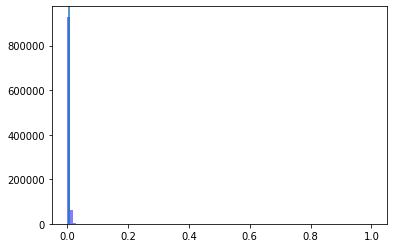

In [65]:
bins = np.linspace(0,1,100)
bins.shape
column = 14
print(f_rnd.columns[column])
plt.hist(X[bkg_idx,column],bins,alpha=0.5,color='b');
#plt.hist(out[:,column],bins,alpha=0.5,color='r');
plt.axvline(np.mean(X[bkg_idx,column]))

In [24]:
X[signal_idx].shape

(100000, 94)

In [25]:
loss_bkg = get_loss(X[bkg_idx])
loss_sig = get_loss(X[signal_idx])

(1000000, 94)
(100000, 94)


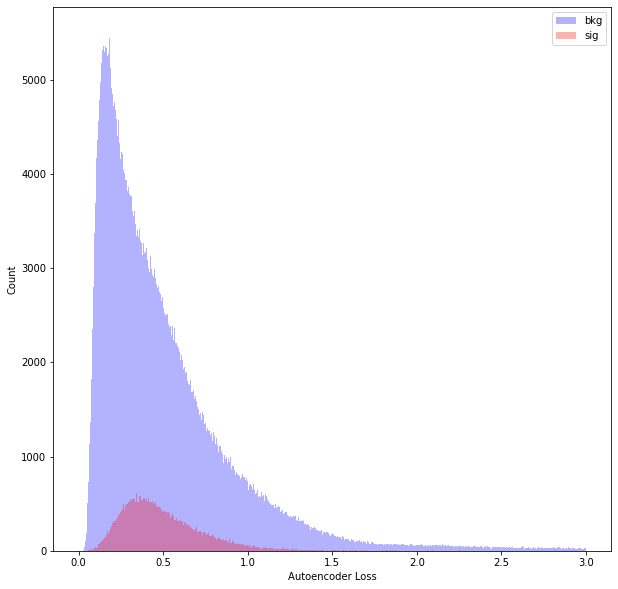

In [26]:
plt.rcParams["figure.figsize"] = (10,10)
bins = np.linspace(0,3,1100)
plt.hist(loss_bkg,bins=bins,alpha=0.3,color='b',label='bkg')
plt.hist(loss_sig,bins=bins,alpha=0.3,color='r',label='sig')
plt.xlabel(r'Autoencoder Loss')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.show()

In [ ]:
def get_tpr_fpr(sigloss,bkgloss,aetype='sig'):
    bins = np.linspace(0,50,1001)
    tpr = []
    fpr = []
    for cut in bins:
        if aetype == 'sig':
            tpr.append(np.where(sigloss<cut)[0].shape[0]/len(sigloss))
            fpr.append(np.where(bkgloss<cut)[0].shape[0]/len(bkgloss))
        if aetype == 'bkg':
            tpr.append(np.where(sigloss>cut)[0].shape[0]/len(sigloss))
            fpr.append(np.where(bkgloss>cut)[0].shape[0]/len(bkgloss))
    return tpr,fpr        

In [ ]:
bkg_tpr, bkg_fpr = get_tpr_fpr(loss_sig,loss_bkg,aetype='bkg')

In [ ]:
np.save('NFLOWVAE_PlanarNEW_bkgAE_fpr.npy',bkg_fpr)
np.save('NFLOWVAE_PlanarNEW_bkgAE_tpr.npy',bkg_tpr)

In [ ]:
plt.plot(bkg_fpr,bkg_tpr,label='Bkg NFlowVAE-Planar')


In [ ]:
def get_precision_recall(sigloss,bkgloss,aetype='bkg'):
    bins = np.linspace(0,100,1001)
    tpr = []
    fpr = []
    precision = []
    for cut in bins:
        if aetype == 'sig':
            tpr.append(np.where(sigloss<cut)[0].shape[0]/len(sigloss))
            precision.append((np.where(sigloss<cut)[0].shape[0])/(np.where(bkgloss<cut)[0].shape[0]+np.where(sigloss<cut)[0].shape[0]))
            
        if aetype == 'bkg':
            tpr.append(np.where(sigloss>cut)[0].shape[0]/len(sigloss))
            precision.append((np.where(sigloss>cut)[0].shape[0])/(np.where(bkgloss>cut)[0].shape[0]+np.where(sigloss>cut)[0].shape[0]))
    return precision,tpr      

In [ ]:
precision,recall = get_precision_recall(loss_sig,loss_bkg,aetype='bkg')

In [ ]:
np.save('NFLOWVAE_PlanarNEW_22var_sigloss.npy',loss_sig)
np.save('NFLOWVAE_PlanarNEW_22var_bkgloss.npy',loss_bkg)

In [ ]:
np.save('NFLOWVAE_PlanarNEW_precision.npy',precision)
np.save('NFLOWVAE_PlanarNEW_recall.npy',recall)
np.save('NFLOWVAE_PlanarNEW_bkgAE_fpr.npy',bkg_fpr)
np.save('NFLOWVAE_PlanarNEW_bkgAE_tpr.npy',bkg_tpr)
np.save('NFLOWVAE_PlanarNEW_sigloss.npy',loss_sig)
np.save('NFLOWVAE_PlanarNEW_bkgloss.npy',loss_bkg)

In [ ]:
plt.plot(recall,precision)

In [ ]:
flows = [1,2,3,4,5,6]
zdim = [1,2,3,4,5]

for N_flows in flows:
    for Z_DIM in zdim:
        model = VAE_NF(N_FLOWS, Z_DIM).cuda()
        optimizer = optim.Adam(model.parameters(), lr=LR)
        BEST_LOSS = 99999
        LAST_SAVED = -1
        PATIENCE_COUNT = 0
        PATIENCE_LIMIT = 5
        for epoch in range(1, N_EPOCHS):
            print("Epoch {}:".format(epoch))
            train()
            cur_loss = evaluate()

            if cur_loss <= BEST_LOSS:
                PATIENCE_COUNT = 0
                BEST_LOSS = cur_loss
                LAST_SAVED = epoch
                print("Saving model!")
                if mode == 'ROC':
                    torch.save(model.state_dict(),f"/data/t3home000/spark/QUASAR/weights/bkg_vae_NF_planar_RND_22var_z{Z_DIM}_f{N_FLOWS}.h5")
                else:
                    torch.save(model.state_dict(), f"/data/t3home000/spark/QUASAR/weights/bkg_vae_NF_planar_PureBkg_22var_z{Z_DIM}_f{N_FLOWS}.h5")
            else:
                PATIENCE_COUNT += 1
                print("Not saving model! Last saved: {}".format(LAST_SAVED))
                if PATIENCE_COUNT > 3:
                    print("Patience Limit Reached")
                    break 
                    
        loss_bkg = get_loss(dt_PureBkg[bkg_idx])
        loss_sig = get_loss(dt_PureBkg[signal_idx])
        np.save(f'NFLOWVAE_PlanarNEW_22var_z{Z_DIM}_f{N_flows}_sigloss.npy',loss_sig)
        np.save(f'NFLOWVAE_PlanarNEW_22var_z{Z_DIM}_f{N_flows}_bkgloss.npy',loss_bkg)